## Рекомендательная система

### Этап 1. Подготовка данных

In [ ]:
import pandas as pd
import numpy as np

# модуль sparse библиотеки scipy понадобится
# для работы с разреженными матрицами (об этом ниже)
from scipy.sparse import csr_matrix

# из sklearn импортируем алгоритм k-ближайших соседей
from sklearn.neighbors import NearestNeighbors

Для начала прочитаем внешние файлы

In [ ]:
# прочитаем внешние файлы (перед этим их необходимо импортировать) и преобразуем в датафрейм
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')

In [ ]:
# посмотрим на содержимое файла movies.csv
# дополнительно удалим столбец genres, он нам не нужен
# (параметр axis = 1 говорит, что мы работаем со столбцами, inplace = True, что изменения нужно сохранить)
movies.drop(['genres'], axis = 1, inplace = True)
movies.head(3)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)


In [ ]:
# и ratings.csv (здесь также удаляем ненужный столбец timestamp)
ratings.drop(['timestamp'], axis = 1, inplace = True)
ratings.head(3)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0


In [ ]:
# для этого воспользуемся функцией pivot и создадим сводную таблицу (pivot table)
# по горизонтали будут фильмы, по вертикали - пользователи, значения - оценки
user_item_matrix = ratings.pivot(index = 'movieId', columns = 'userId', values= 'rating')
user_item_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# пропуски NaN нужно преобразовать в нули
# параметр inplace = True опять же поможет сохранить результат
user_item_matrix.fillna(0, inplace = True)
user_item_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# посмотрим на размерность матрицы "пользователи х фильмы"
user_item_matrix.shape

(9724, 610)

Теперь давайте уберем неактивных пользователей и фильмы с небольшим количеством оценок

In [ ]:
# вначале сгруппируем (объединим) пользователей, возьмем только столбец rating
# и посчитаем, сколько было оценок у каждого пользователя
users_votes = ratings.groupby('userId')['rating'].agg('count')

# сделаем то же самое, только для фильма
movies_votes = ratings.groupby('movieId')['rating'].agg('count')

In [ ]:
# теперь создадим фильтр (mask)
user_mask = users_votes[users_votes > 50].index
movie_mask = movies_votes[movies_votes > 10].index

In [ ]:
# применим фильтры и отберем фильмы с достаточным количеством оценок,
user_item_matrix = user_item_matrix.loc[movie_mask,:]

# а также активных пользователей
user_item_matrix = user_item_matrix.loc[:,user_mask]

In [ ]:
# посмотрим сколько пользователей и фильмов осталось
user_item_matrix.shape

(2121, 378)

Мы почти завершили первый этап. В частности, осталось преобразовать разреженную матрицу (sparce matrix) в сжатое хранение строкой (сompressed sparse row) с помощью **функции csr_matrix()** библиотеки Scipy.

In [ ]:
# преобразуем разреженную матрицу в формат csr
# метод values передаст функции csr_matrix только значения датафрейма
csr_data = csr_matrix(user_item_matrix.values)

# посмотрим на первые записи
# сопоставьте эти значения с исходной таблицей выше
print(csr_data[:2,:5])

  (0, 0)	4.0
  (0, 3)	4.5
  (1, 2)	4.0


In [ ]:
# остается только сбросить индекс с помощью reset_index()
# это необходимо для удобства поиска фильма по индексу
user_item_matrix = user_item_matrix.rename_axis(None, axis = 1).reset_index()
user_item_matrix.head()

,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


### Этап 2. Обучение модели

In [ ]:
# воспользуемся классом NearestNeighbors для поиска расстояний
knn = NearestNeighbors(metric = 'cosine',
                       algorithm = 'brute',
                       n_neighbors = 20,
                       n_jobs = -1)

# обучим модель
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

### Этап 3. Составление рекомендаций

Зададим изначальные параметры поиска

In [ ]:
# определимся, сколько рекомендаций мы хотим получить
recommendations = 10

# и на основе какого фильма
search_word = 'Matrix'

Найдем индекс фильма в матрице предпочтений

In [ ]:
# найдем фильм в заголовках датафрейма movies
movie_search = movies[movies['title'].str.contains(search_word)]
movie_search

,movieId,title
1939,2571,"Matrix, The (1999)"
4351,6365,"Matrix Reloaded, The (2003)"
4639,6934,"Matrix Revolutions, The (2003)"


In [ ]:
# вариантов может быть несколько, для простоты всегда будем брать первый вариант
# через iloc[0] мы берем первую строку столбца ['movieId']
movie_id = movie_search.iloc[0]['movieId']

# далее по индексу фильма в датасете movies найдем соответствующий индекс
# в матрице предпочтений
movie_id = user_item_matrix[user_item_matrix['movieId'] == movie_id].index[0]
movie_id

901

Находим схожие фильмы

In [ ]:
# теперь нужно найти индексы и расстояния фильмов, которые похожи на наш запрос
# воспользуемся методом kneighbors()
distances, indices = knn.kneighbors(csr_data[movie_id], n_neighbors = recommendations + 1)

In [ ]:
# индексы рекомендованных фильмов
indices

array([[ 901, 1002,  442,  454,  124,  735,  954, 1362, 1157, 1536,  978]])

In [ ]:
# расстояния до них
distances

array([[0.        , 0.22982441, 0.25401128, 0.27565617, 0.27760886,
        0.28691008, 0.29111012, 0.31393358, 0.31405926, 0.31548004,
        0.31748544]])

In [ ]:
# уберем лишние измерения через squeeze() и преобразуем массивы в списки с помощью tolist()
indices_list = indices.squeeze().tolist()
distances_list = distances.squeeze().tolist()

# далее с помощью функций zip() и list() преобразуем списки
indices_distances = list(zip(indices_list, distances_list))

# в набор кортежей (tuple)
print(type(indices_distances[0]))

# и посмотрим на первые три пары/кортежа
print(indices_distances[:3])

<class 'tuple'>
[(901, 0.0), (1002, 0.22982440568634488), (442, 0.25401128310081567)]


In [ ]:
# остается отсортировать список по расстояниям через key = lambda x: x[1] (то есть по второму элементу)
# в возрастающем порядке reverse = False
indices_distances_sorted = sorted(indices_distances, key = lambda x: x[1], reverse = False)

# и убрать первый элемент с индексом 901 (потому что это и есть "Матрица")
indices_distances_sorted = indices_distances_sorted[1:]
indices_distances_sorted

[(1002, 0.22982440568634488),
 (442, 0.25401128310081567),
 (454, 0.27565616686043737),
 (124, 0.2776088577731709),
 (735, 0.2869100842838125),
 (954, 0.2911101181714415),
 (1362, 0.31393358217709477),
 (1157, 0.31405925934381695),
 (1536, 0.3154800434449465),
 (978, 0.31748544046311844)]

Остается найти, какие фильмы соответствуют найденным индексам

In [ ]:
# создадим пустой список, в который будем помещать название фильма и расстояние до него
recom_list = []

# в цикле будем поочередно проходить по кортежам
for ind_dist in indices_distances_sorted:

    # искать movieId в матрице предпочтений
    matrix_movie_id = user_item_matrix.iloc[ind_dist[0]]['movieId']

    # выяснять индекс этого фильма в датафрейме movies
    id = movies[movies['movieId'] == matrix_movie_id].index

    # брать название фильма и расстояние до него
    title = movies.iloc[id]['title'].values[0]
    dist = ind_dist[1]

    # помещать каждую пару в питоновский словарь,
    # который, в свою очередь, станет элементом списка recom_list
    recom_list.append({'Title' : title, 'Distance' : dist})

In [ ]:
# посмотрим на первый элемент
recom_list[0]

{'Title': 'Fight Club (1999)', 'Distance': 0.22982440568634488}

In [ ]:
# остается преобразовать список в датафрейм
# индекс будем начинать с 1, как и положено рейтингу
recom_df = pd.DataFrame(recom_list, index = range(1, recommendations + 1))
recom_df

,Title,Distance
1,Fight Club (1999),0.229824
2,Star Wars: Episode V - The Empire Strikes Back...,0.254011
3,Star Wars: Episode VI - Return of the Jedi (1983),0.275656
4,Star Wars: Episode IV - A New Hope (1977),0.277609
5,Saving Private Ryan (1998),0.286910
6,"Sixth Sense, The (1999)",0.291110
7,"Lord of the Rings: The Fellowship of the Ring,...",0.313934
8,Gladiator (2000),0.314059
9,"Lord of the Rings: The Return of the King, The...",0.315480
10,American Beauty (1999),0.317485


### Ответы на вопросы

**Вопрос**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Векторы на графике

In [ ]:
# создадим два вектора с координатами [10, 10] и [1, 1]
x = np.array([10, 10])
y = np.array([1, 1])

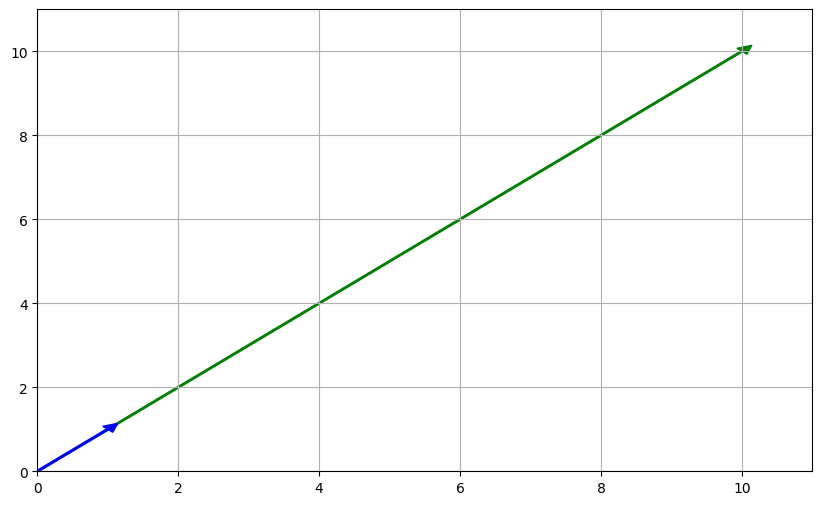

In [ ]:
# зададим размер фигуры (контейнера, в который помещаются графики)
plt.figure(figsize = (10, 6))

# создадим объект графика внутри этой фигуры
ax = plt.axes()

# зададим диапазон осей x и y
plt.xlim([0, 11])
plt.ylim([0, 11])
plt.grid()

# "подграфиками" будут два вектора в форме стрелок
ax.arrow(0, 0, x[0], x[1], width = 0.03, head_width = 0.2, head_length = 0.2, fc = 'g', ec = 'g')
ax.arrow(0, 0, y[0], y[1], width = 0.03, head_width = 0.2, head_length = 0.2, fc = 'b', ec = 'b')

plt.show()

Расчет косинусного сходства

In [ ]:
# напишем функцию для расчета косинусного сходства
def similar(x, y):

    # рассчитаем длины векторов
    xLen = np.linalg.norm(x)
    yLen = np.linalg.norm(y)

    # подставим их в формулу косинусного сходства
    result = np.dot(x, y)/(xLen * yLen)

    # выведем результат
    return result

In [ ]:
# ожидаемо косунус угла будет равен единице
round(similar(x, y), 3)

1.0

Item-based система

In [ ]:
# создадим массив Numpy с оценками
films = np.array(
    [
     [1, 3, 2, 6, 2, 1, 0],
     [0, 2, 0, 3, 0, 6, 2],
     [1, 1, 1, 1, 1, 1, 1],
     [2, 4, 1, 3, 9, 2, 1],
     [10, 10, 10, 10, 10, 10, 10]
     ]
)

# строки это фильмы, столбцы - пользователи
films

array([[ 1,  3,  2,  6,  2,  1,  0],
       [ 0,  2,  0,  3,  0,  6,  2],
       [ 1,  1,  1,  1,  1,  1,  1],
       [ 2,  4,  1,  3,  9,  2,  1],
       [10, 10, 10, 10, 10, 10, 10]])

In [ ]:
# предположим, вышел новый фильм, и все пользователи поставили ему рейтинг 10
new_film = np.array([10, 10, 10, 10, 10, 10, 10])

In [ ]:
# в цикле for поочередно рассчитаем косинусное сходство каждого из имеющхся фильмов с новым фильмом
for i, film in enumerate(films, 1):
  print(f'Фильм {i} с оценками {film} имеет сходство с новым фильмом {np.round(similar(film, new_film), 3)}')

Фильм 1 с оценками [1 3 2 6 2 1 0] имеет сходство с новым фильмом 0.764
Фильм 2 с оценками [0 2 0 3 0 6 2] имеет сходство с новым фильмом 0.675
Фильм 3 с оценками [1 1 1 1 1 1 1] имеет сходство с новым фильмом 1.0
Фильм 4 с оценками [2 4 1 3 9 2 1] имеет сходство с новым фильмом 0.772
Фильм 5 с оценками [10 10 10 10 10 10 10] имеет сходство с новым фильмом 1.0
